In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob
import pickle
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_distances
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
class tsne_plot:
    def __init__(self):
        None
    
    def plot(features,file_path_csv,save_fig=True):

        file_path_list = list(pd.read_csv(file_path_csv)['0'])
        features = pd.read_pickle(features)
        print("Generating TSNE features ...")
        tsne_2D = TSNE(n_components=2).fit_transform(features)

        print("Plotting 100 samples from the given image folder")
        sample_img = np.random.choice(len(file_path_list), 100)
        img_to_plot = [file_path_list[i] for i in sample_img]

        tx = tsne_2D[sample_img, 0]
        ty = tsne_2D[sample_img, 1]

        tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
        ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

        width = 4000
        height = 3000
        max_dim = 125

        image_plot = Image.new('RGBA', (width, height))
        for img, x, y in zip(img_to_plot, tx, ty):
            tile = Image.open(img)
            rs = max(1, tile.width/max_dim, tile.height/max_dim)
            tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
            image_plot.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
        

        plt.figure(figsize=(16, 12))
        plt.imshow(image_plot)
        image_plot.save("Feature_Map.png")

In [3]:
class pca_similarity:
        def __init__(self):
                None
                
        def pca_on_features(features, n_components=100, save_results=True):
                print("Generating PCA of the given data ...")
                pca = PCA(n_components=n_components)
                pca.fit(features)
                pca_features = pca.transform(features)
                if save_results:
                        with open('pca_features.pkl', 'wb') as fh:
                                pickle.dump(np.array(pca_features), fh)
                        print("Saved pca featuers as {}".format('pca_features.pkl'))

In [4]:
class vector_similarity(tsne_plot,pca_similarity):
    def __init__(self,folder_path):
        self.file_path = glob(folder_path+'/*.jpg') #[ glob(folder+'/*.jpg') for folder in glob(folder+'/*')]
        print("Found {} number of images at {}".format(len(self.file_path),folder_path))
        self.feature_extractor = self.load_model()

    def load_model(self):
        vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
        feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=vgg16.get_layer("fc2").output)
        print("Using pretrained VGG16 for feature extraction.")
        return feature_extractor

    def feature_extraction(self,image_path):
        img = tf.keras.preprocessing.image.load_img(image_path)
        img = img.resize((224, 224))
        img = np.expand_dims(img, axis=0)
        features = self.feature_extractor.predict(img,verbose=False)
        return features
    
    def save_feature(self,feature_list,file_name='features.pkl'):
        features = np.array(feature_list)
        features.resize(len(feature_list), 4096)
        #somehow the pickle file was adding an all zero array so removing that using the below line of code
        features = features[~np.all(features == 0, axis=1)]

        with open(file_name, 'wb') as fh:
            pickle.dump(features, fh)
        print("Saved features as pickle file at {} ".format(file_name))
    
    def save_path(self,path_list,file_name='image_path.csv'):
        (pd.DataFrame(path_list)).to_csv(file_name)
        print("Saved relative image path as csv file at {} ".format(file_name))
    
    def create_features(self):
        print("Extracting features ...")
        features = []
        for x in self.file_path:
            features.append(self.feature_extraction(x))
        
        self.save_feature(features)
        self.save_path(self.file_path)
    
    def cosine_similarity(self,vector_1,vector_2):
        return 1 - spatial.distance.cosine(vector_1[0], vector_2)

    def test_similarity(self,feature_path,relative_path,test_file):
        print("Using features stores at {}".format(feature_path))

        self.pickle_file = pd.read_pickle(feature_path)

        relative_path = pd.read_csv(relative_path)
        relative_path.columns = ['index','path']

        feature_vector = self.feature_extraction(test_file)

        scores = [ self.cosine_similarity(feature_vector,self.pickle_file[i]) for i in range(self.pickle_file.shape[0])]
        
        relative_path['Scores'] = scores
    
        relative_path.columns = ['index','path','Scores']
        relative_path = (relative_path.sort_values(by='Scores',ascending=False)).reset_index()
        relative_path.drop(columns=relative_path.columns[:-2],axis=1,inplace=True)
        
        return relative_path
    
    def pca_on_features(self,feature):
        pca_similarity.pca_on_features(features=feature)

    def tsne_analysis(self,feature,path):
        tsne_plot.plot(feature,file_path_csv=path)

In [5]:
def plot(path):
    img = tf.keras.preprocessing.image.load_img(path)
    imgplot = plt.imshow(img)
    plt.show()

In [6]:
image_similarity = vector_similarity(folder_path='./data/sample_data')

Found 1553 number of images at ./data/sample_data
Using pretrained VGG16 for feature extraction.


In [7]:
image_similarity.create_features()

Extracting features ...


2022-11-16 12:59:12.302397: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Saved features as pickle file at features.pkl 
Saved relative image path as csv file at image_path.csv 


In [8]:
image_similarity.pca_on_features(feature=pd.read_pickle('features.pkl'))

Generating PCA of the given data ...
Saved pca featuers as pca_features.pkl


Generating TSNE features ...
Plotting 100 samples from the given image folder


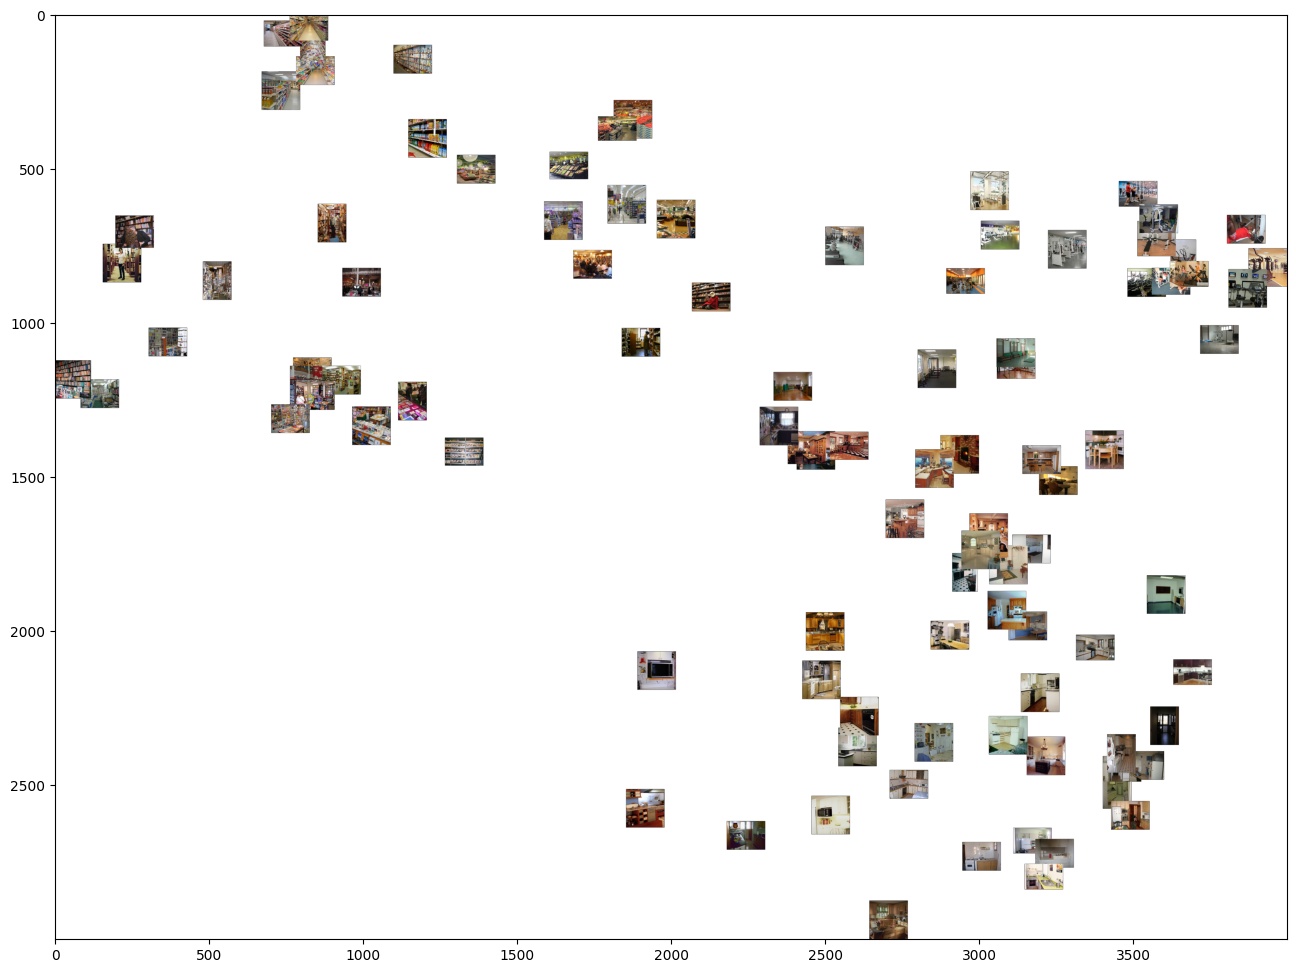

In [9]:
image_similarity.tsne_analysis(feature='pca_features.pkl',path='image_path.csv')

In [10]:
test_file = './data/test_data/test_1.jpg'
df = image_similarity.test_similarity(feature_path='features.pkl',relative_path='image_path.csv',test_file=test_file)

Using features stores at features.pkl


In [11]:
df.head()

,path,Scores
0,./data/sample_data/gimnasio_60_19_flickr.jpg,0.693859
1,./data/sample_data/gimnasio_78_14_flickr.jpg,0.656974
2,./data/sample_data/int380.jpg,0.652243
3,./data/sample_data/gym_15_04_altavista.jpg,0.649117
4,./data/sample_data/kitchen086.jpg,0.648345


Given test image


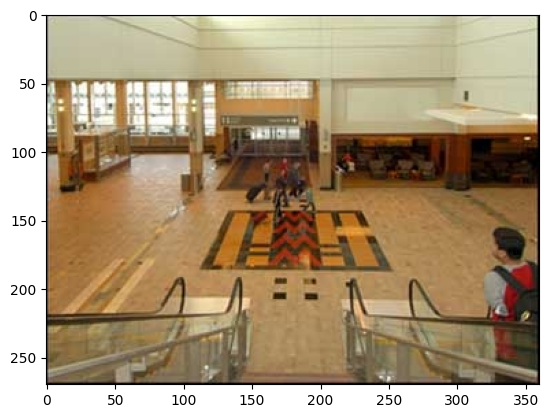

Top 5 similar images in database ...
similarity matching score: 0.6938589215278625


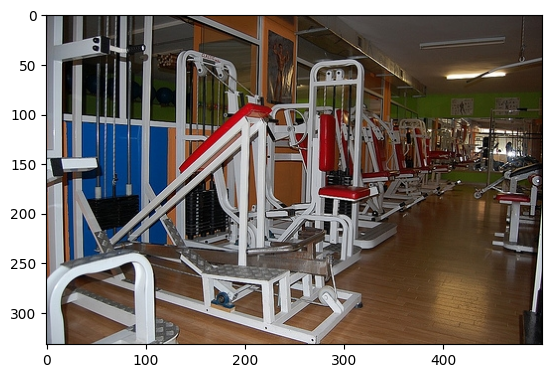

similarity matching score: 0.6569736003875732


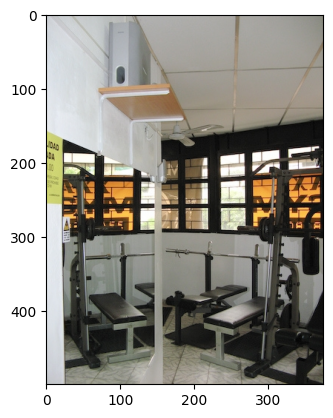

similarity matching score: 0.6522433757781982


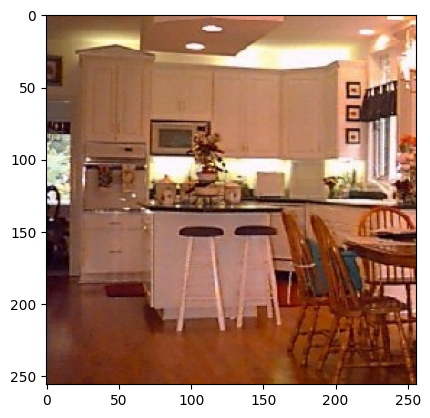

similarity matching score: 0.6491166353225708


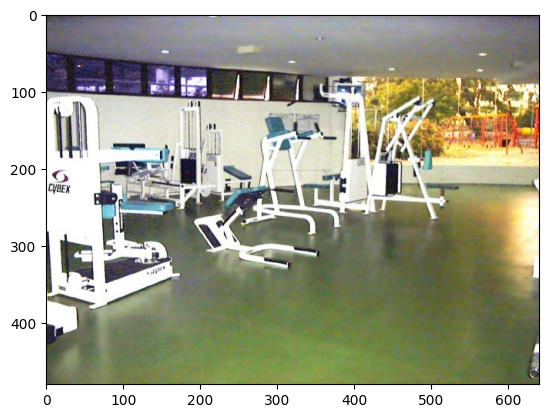

similarity matching score: 0.6483446955680847


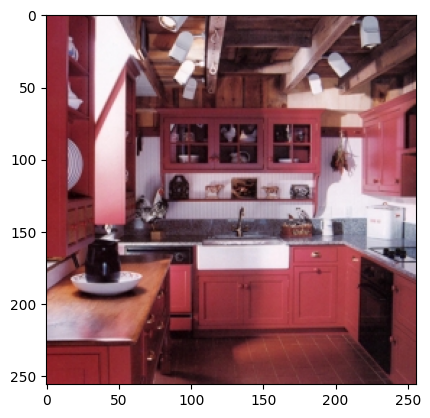

In [12]:
print("Given test image")
plot(test_file)
print('Top 5 similar images in database ...')
for i in range(5):
    print("similarity matching score: {}".format(df.Scores[i]))
    plot(df.path[i])